In [1]:
pip install --force-reinstall git+https://github.com/amyfricke/clairvoyants.git

  Cloning https://github.com/amyfricke/clairvoyants.git to /tmp/pip-req-build-k_8vmex4
  Running command git clone --filter=blob:none --quiet https://github.com/amyfricke/clairvoyants.git /tmp/pip-req-build-k_8vmex4
  Resolved https://github.com/amyfricke/clairvoyants.git to commit d4f341abe679cfe4146e4759dbb037de60230fef
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (2.1 kB)
  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (2.2 kB)
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (6.7 kB)
  Using cached statsmodels-0.13.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.5 kB)
  Using cached pm

    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: zipp
    Found existing installation: zipp 3.15.0
    Uninstalling zipp-3.15.0:
      Successfully uninstalled zipp-3.15.0
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.67.1
    Uninstalling tqdm-4.67.1:
      Successfully uninstalled tqdm-4.67.1
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.1.0
    Uninstalling threadpoolctl-3.1.0:
      Successfully uninstalled threadpoolctl-3.1.0
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:


# Using Clairvoyants to do Attribution
Goal: Show how to use clairvoyants to (1) fit an ensemble of forecasting model on simulated subscriber counts for a fictional online tutoring company and (2) attribute movement in subscribers to specific drivers including:

* School referral program

* Marketing Channel A

* Marketing Channel B

* Social media influencers

* Report cards coming out (calendar event)

* Pandemic (exogenous shock)

* Other / unknown

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

from clairvoyants import Clairvoyant
from clairvoyants import ensemble
from clairvoyants.plot import human_format, plot_attributions3


Importing plotly failed. Interactive plots will not work.


## Read in the data from the examples folder
We begin by reading in the example dataset, which contains simulated subscriber counts for a fictional online tutoring company. The dataset includes the required columns 'dt' (date) and 'actual' (observed subscriber counts), which serve as inputs for clairvoyants. 

In [3]:
tutoring_subscribers = pd.read_csv("../examples/tutoring_subscribers.csv")
tutoring_subscribers['dt'] = pd.to_datetime(tutoring_subscribers.dt)

Next, we load the covariate dataset. Like the target data, it must include a 'dt' column. Importantly, the covariate values must cover both the training window and the forecast horizon, since clairvoyants does not generate forecasts for the features themselves.

In this example, the covariates represent several potential drivers of subscriber growth, including:

* Marketing spend for Channels A and B

* A school referral program

* Social media influencer spend

* An indicator for periods when COVID restrictions were in place

In [4]:
tutoring_features = pd.read_csv("../examples/tutoring_covariates.csv")
tutoring_features['dt'] = pd.to_datetime(tutoring_features.dt)

Next, we load an example dataset to demonstrate how clairvoyants handles holidays. Holidays (or similar calendar events) are modeled as special regressors that can capture short-term, recurring effects not explained by baseline trends or marketing spend.

In this example, we include:

* Summer break: a longer holiday period when subscriber activity may dip.

* New Year’s Eve / report card release: a single-day event that can drive a temporary spike in new subscribers.

By explicitly flagging these events, clairvoyants can better attribute subscriber changes to predictable calendar effects rather than misattributing them to other factors. 

In [5]:
holidays_df = pd.read_csv("../examples/holidays_df_example.csv")
holidays_df['dt'] = pd.to_datetime(holidays_df.dt)

## Fitting the clairvoyant ensemble
Now we configure the forecasting object. In this example, we specify an ensemble of four models: two SARIMA models and two neural network models. We leave the transform option as None, which produces additive models. (If transform='log' were specified, the models would instead be multiplicative.)

We also pass in our holiday DataFrame and disable the default annual seasonality. This choice reflects the way the data was simulated—seasonal patterns are already captured by the holiday factors, so adding a generic yearly seasonality term would be redundant. 

In [6]:
tutoring_clairvoyant = Clairvoyant(models=[ensemble.sarimax_013_011,
                                           ensemble.auto_sarif_nnet,
                                           ensemble.auto_scarf_nnet,
                                           ensemble.sarimax_003_001],
                                  transform='none',
                                  periods_trig=[],
                                  holidays_df=holidays_df)

Next, we fit the ensemble to the clairvoyants forecast object. This is the stage where we provide the features dataset we loaded earlier. These features include the key factors—such as marketing spend, school referrals, and holiday indicators—that the model will use to explain and attribute changes in subscriber counts.

In [7]:
tutoring_clairvoyant = tutoring_clairvoyant.fit_ensemble(df=tutoring_subscribers,
                                                 training_end_dt=datetime(2022, 1, 10),
                                                 forecast_end_dt=datetime(2022, 9, 14),
                                                 x_features=tutoring_features)


/home/amyrichardson/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/home/amyrichardson/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amyrichardson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/amyrichardson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/amyrichardson/anaconda3/lib/python3.7/site-packages/statsmodels

## Attribution from the forecast model ensemble
The forecasting models can separate the effects of different exogenous factors (such as marketing spend or school referrals) from seasonal and holiday-driven effects. Below, we plot the attribution results from the consensus model. By default, the consensus is calculated as the renormalized median attribution across the four individual forecast models in the ensemble. This provides a stable, aggregated view of how much each factor contributed to subscriber changes over time.

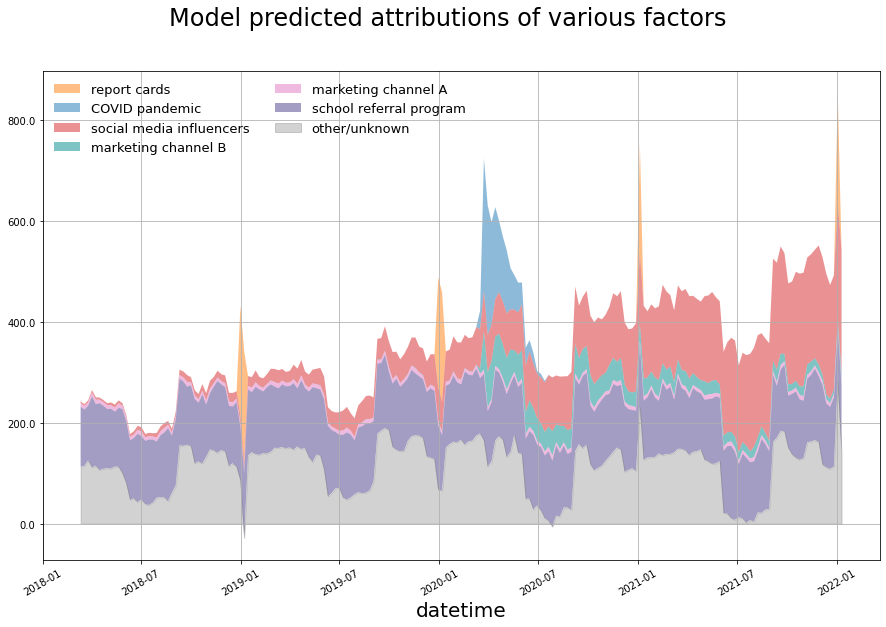

In [8]:
plot_attributions3(tutoring_clairvoyant.ensemble_model_artifacts['attributions']['consensus'], 
                   { 'report cards': ['NewYears'], 'COVID pandemic': ['covid'],
                    'social media influencers': ['social_media_influencers'],
                   'marketing channel B':['marketing_channel_a'], 
                    'marketing channel A':['marketing_channel_b'],
                   'school referral program':['school_referral_program']})


Each shaded color in the plot represents the influence of various factors on the total number of
tutoring subscribers over time, based on the collective insight of a set of machine learning
models trained with features for each factor, along with traditional temporal features.
The visualization reveals several key trends. Initially, the primary driver of subscribers for the
fictional online tutoring company was a school referral program, with minimal additional impact
from marketing channel A. However, at the end of each year, there's a notable uptick in
subscribers coinciding with mid-year report cards. Another more dramatic surge occurs with the
onset of the COVID-19 pandemic, resulting in a significant ultimately unsustained increase in
subscribers. Meanwhile, the impact of marketing channel B on subscriber numbers was fair

when it was initiated at the start of the pandemic, although this effect slowly diminishes by the
end of 2021. Throughout the company's subscriber history, social media influencers gradually
become a more influential factor. By the close of 2021, social media influencers appear to be
driving more subscribers to the online tutoring platform than the referral program, which had
been the primary source of subscribers historically.

We can also look at individual models attribution results, below is that of the SARIMA(0,0,3)(0,0,1) model which looks remarkably like the consensus result. 

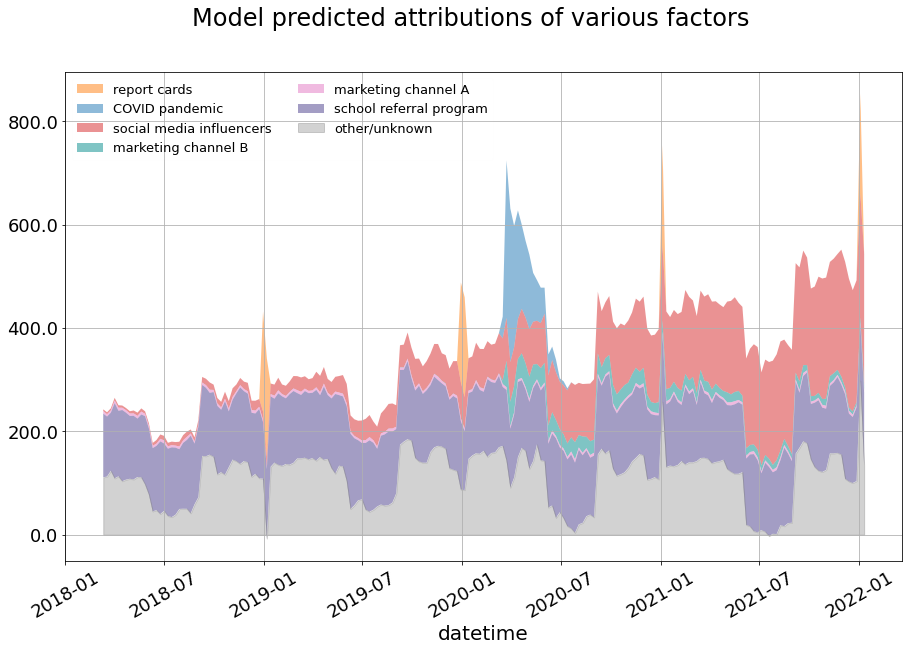

In [9]:
plot_attributions3(tutoring_clairvoyant.ensemble_model_artifacts['attributions']['sarimax_003_001'], 
                   { 'report cards': ['NewYears'], 'COVID pandemic': ['covid'],
                    'social media influencers': ['social_media_influencers'],
                   'marketing channel B':['marketing_channel_a'], 
                    'marketing channel A':['marketing_channel_b'],
                   'school referral program':['school_referral_program']})